# <span style='font-family:rockwell'>  <span style='color:black'> ***Bradford Assay***

### <span style='font-family:rockwell'>  <span style='color:black'> **Data Processor**

Output()

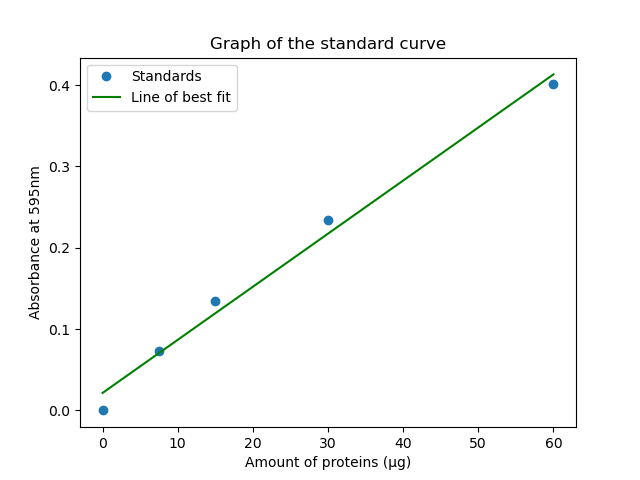

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import io 
from IPython.display import display
import numpy as np
import scipy.stats as stats
import ipympl

uploader = widgets.FileUpload(description = "Upload your file: xlsx", multiple=False)
uploader.layout.width = '200px'
process_btn = widgets.Button(description = "Process data", button_style='success')
graph_btn = widgets.Button(description = "Display graph", button_style='info')

display(widgets.HBox([uploader, process_btn, graph_btn]))

out = widgets.Output()
display(out)


# calculates the concentration using the absorbance_value, m & c values  
def calconc (gradient, intercept, absorbance):
    concentration = (absorbance - intercept) / gradient
    return round(concentration, 3)
        
# calculates required volume to get the the desired amount of proteins from a sample under a particular condition
def calcvol (Protein_μg_aliquot, Aliquot_volume_μl, desired_protein_μg):
    required_volume = (desired_protein_μg*Aliquot_volume_μl)/Protein_μg_aliquot    
    return round(required_volume, 3)

# calculates the amount of proteins in the entire sample using aliquot amounts
def calcsampleconc (Protein_μg_aliquot, ALiquot_volume_μl, Sample_volume_ml):
    Sample_volume_μl = Sample_volume_ml*1000
    Protein_μg_sample = (Sample_volume_μl*Protein_μg_aliquot)/ALiquot_volume_μl
    return Protein_μg_sample

def on_upload_change(uploaded_file):
    global content
    with out:
        uploaded_file = list(uploader.value.values())[0]
        content = pd.read_excel(io.BytesIO(uploaded_file['content']))
        return display(content)

def data_processing(on_upload_change):
        global conc, abso, m, c
        with out:
        
            #reading data from the columns
            conc = content[content.Standard_Unknown =='S']['Protein_μg_sample']
            abso = content[content.Standard_Unknown =='S']['Absorbance_nm']
            
            #line of best fit using polyfit function
            m, c = np.polyfit(conc, abso, 1)
                        
            content['Condition_name'] = content['Condition_name'].str.lower()

            #group by Condition num/name, avg the abso values, name the new columns, round the avg values
            content_mean = content.groupby(['Condition_number', 'Condition_name'])['Absorbance_nm'].mean().round(3).rename('Average_absorbance_nm').reset_index()

            #merge the new column with the main index
            content_1 = content.merge(content_mean)
            
            #calculate the amount of proteins using the absorbance values
            content_1.loc[content_1.Standard_Unknown =='U','Protein_μg_aliquot'] = calconc(m, c, content_1['Average_absorbance_nm'])

            #drop unnecessary columns
            content_2 = content_1.drop(['Absorbance_nm', 'Replicate_number'], 1)

            #drop repetetive rows
            content_2.drop_duplicates(['Condition_number', 'Condition_name'], keep='first', inplace=True)
            content_2.reset_index(drop=True, inplace=True)

            #calculate volume to get desired amount of proteins. Default set to 100μg
            content_2.loc[content_2.Standard_Unknown =='U', ['Volume_for_100μg']] = calcvol (content_2['Protein_μg_aliquot'], content_2['Aliquot_volume_μl'], 100)

            #calculate the amount of protein in entire sample based on amounts in aliquot 
            content_2.loc[content_2.Standard_Unknown =='U','Protein_μg_sample'] = calcsampleconc(content_2['Protein_μg_aliquot'], content_2['Aliquot_volume_μl'], content_2['Sample_volume_ml'])
            
            return display(content_2)

def graph_creator(self):
        with out:
            #layout of the graph
            plt.ylabel('Absorbance at 595nm')
            plt.xlabel('Amount of proteins (μg)')
            plt.title('Graph of the standard curve')
            
            #plot the data points,   # plot the line of best fit
            plt.plot(conc, abso, 'o')
            plt.plot(conc, m*conc+c, 'g-')

            plt.legend(['Standards', 'Line of best fit'])
            plt.savefig()
            return plt.show()
        
def test_button(self):
    with out:
        return print("the button works!")

uploader.observe(on_upload_change, names='value') 
process_btn.on_click(data_processing)
#graph_btn.on_click(test_button)
graph_btn.on_click(graph_creator)